# Load libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected='true')
import os

# Load Data

In [2]:
data = pd.read_csv('full_data.csv', delimiter=',', parse_dates = ['timestamp'])

print('*' * 20, 'Data Preview: ', '*' * 20,'\n', data.head(), '\n', '****' * 20)
print('*' * 20, 'Data Describtion: ', '*' * 20,'\n', data.describe(), '\n', '****' * 20)
print('*' * 20, 'Data Shape: ', '*' * 20,'\n', data.shape, '\n', '****' * 20)

******************** Data Preview:  ******************** 
             timestamp  electricity  air_temperature  dew_temperature  \
0 2016-01-01 00:00:00         17.7              3.8              2.4   
1 2016-01-01 01:00:00         37.1              3.7              2.4   
2 2016-01-01 02:00:00         37.8              2.6              1.9   
3 2016-01-01 03:00:00         35.1              2.0              1.2   
4 2016-01-01 04:00:00         27.5              2.3              1.8   

   sea_level_pressure  wind_direction  wind_speed  month  day  weekday  hour  
0              1020.9               5         3.1      1    1        5     0  
1              1021.6               5         2.6      1    1        6     1  
2              1021.9               0         0.0      1    1        7     2  
3              1022.3               4         1.5      1    1        1     3  
4              1022.7               2         1.5      1    1        2     4   
 ********************************

# Visualization

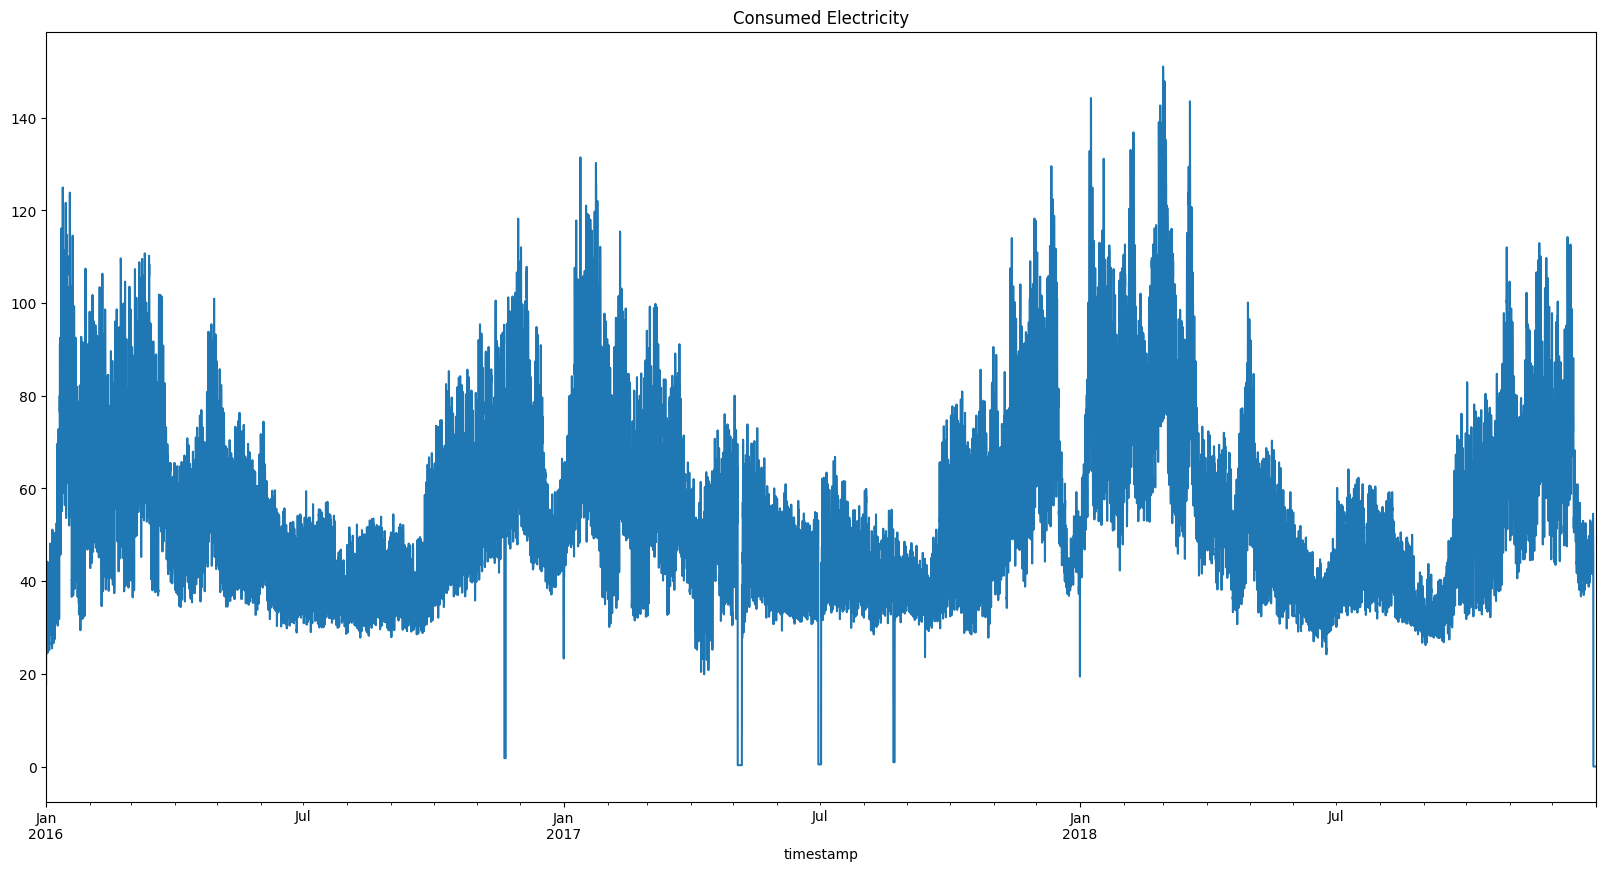

In [3]:
data = data.set_index('timestamp')
data['electricity'].plot(title='Consumed Electricity', figsize=(20,10));


# Preprocessing

In [4]:
def convert_data(data, look_back = 1, dropnan=True):
    df = data
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(look_back, 0, -1):
        cols.append(data.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in data.columns]

    # forecast (t) only for electricity(label/class)
    cols.append(df.shift(0)['electricity'])
    names += ['electricity(t)']

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg



In [5]:
def create_dataset(data, look_back):
  dataset = convert_data(data = data, look_back = look_back, dropnan=True)
  dataset = dataset.astype('float32')

  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)

  # split into train and test sets
  train_size = int(len(dataset) * 0.70)
  test_size = len(dataset) - train_size
  X_train, y_train, X_test, y_test = dataset[0:train_size,0:-1], dataset[0:train_size,-1], \
                dataset[-test_size:,0:-1], dataset[-test_size:,-1]

  # reshape input to be [samples, time steps, features]
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

  return X_train, y_train, X_test, y_test

look_back = 12
X_train, y_train, X_test, y_test = create_dataset(data, look_back)

# Model

In [6]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, num_dir, device):
        super(LSTM, self).__init__()

        self.device = device
        self.num_classes = num_classes #number of outputs
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.num_directions = num_dir

        if num_dir == 2:
            bi = True
        else:
            bi = False

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional = bi ) #lstm
        self.fc_1 =  nn.Linear(hidden_size*num_dir, 100) #fully connected 1
        self.fc = nn.Linear(100, num_classes) #fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(
              self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device) #hidden state
        c_0 = Variable(torch.zeros(
            self.num_layers*self.num_directions, x.size(0), self.hidden_size)).to(self.device) #internal state

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = output.view(-1, self.hidden_size*self.num_directions) #reshaping the data for Dense layer next
        out = self.relu(out)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out

In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('T4')
else:
    device = torch.device("cpu")


model = LSTM(num_classes = 1, input_size = X_train_tensors.shape[2], hidden_size=133, num_layers=1, seq_length=X_train_tensors.shape[1],  num_dir = 1, device=device)
model.to(device)
print(model)

T4
LSTM(
  (lstm): LSTM(120, 133, batch_first=True)
  (fc_1): Linear(in_features=133, out_features=100, bias=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([18404])) that is different to the input size (torch.Size([18404, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([7888])) that is different to the input size (torch.Size([7888, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch: 0, loss: 0.16574, val_loss: 0.14216
Epoch: 50, loss: 0.01698, val_loss: 0.01948
Epoch: 100, loss: 0.01643, val_loss: 0.01910
Epoch: 150, loss: 0.01629, val_loss: 0.01899
Epoch: 200, loss: 0.01624, val_loss: 0.01896
Epoch: 250, loss: 0.01622, val_loss: 0.01894
Epoch: 300, loss: 0.01621, val_loss: 0.01893
Epoch: 350, loss: 0.01621, val_loss: 0.01893
Epoch: 400, loss: 0.01621, val_loss: 0.01893
Epoch: 450, loss: 0.01621, val_loss: 0.01893
Epoch: 500, loss: 0.01621, val_loss: 0.01893
Epoch: 550, loss: 0.01621, val_loss: 0.01893
Epoch: 600, loss: 0.01621, val_loss: 0.01893
Epoch: 650, loss: 0.01621, val_loss: 0.01893
Epoch: 700, loss: 0.01621, val_loss: 0.01893
Epoch: 750, loss: 0.01621, val_loss: 0.01893
Epoch: 800, loss: 0.01621, val_loss: 0.01893
Epoch: 850, loss: 0.01621, val_loss: 0.01893
Epoch: 900, loss: 0.01621, val_loss: 0.01893
Epoch: 950, loss: 0.01621, val_loss: 0.01893


Text(0, 0.5, 'MSE loss')

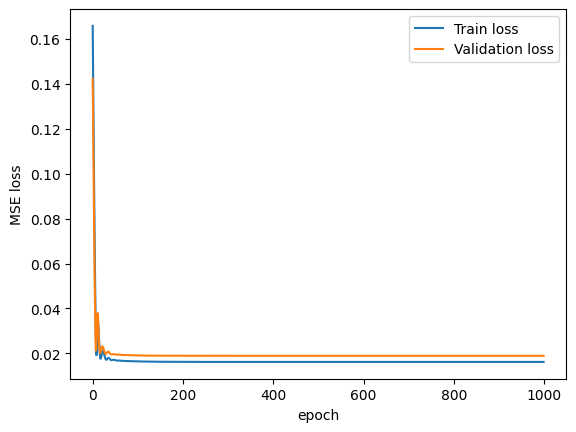

In [10]:
learning_rate = 0.001 #0.001 lr
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 1000 #1000 epochs
#train 1
model.train()

train_loss = []
val_loss = []
X_test_tensors_final = X_test_tensors.to(device)
y_test_tensors = y_test_tensors.to(device)
X_train_tensors_final = X_train_tensors.to(device)
y_train_tensors = y_train_tensors.to(device)

for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
    # obtain the batch loss
    loss = criterion(outputs, y_train_tensors)
    train_loss.append(loss.item())
    loss.backward() #calculates the loss of the loss function
    optimizer.step() #improve from loss, i.e backpropagation

    #validation
    val_out = model.forward(X_test_tensors_final)
    loss_val =criterion(val_out, y_test_tensors)
    val_loss.append(loss_val.item())

    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, train_loss[epoch], val_loss[epoch]))

epoch = np.arange(0,num_epochs)

#plotting
plt.plot(epoch, train_loss, label = "Train loss")
plt.plot(epoch, val_loss, label = "Validation loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE loss')

# Evaluation

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))

y_real = data.iloc[12:,1].to_numpy()

x=scaler.fit_transform(y_real.reshape(1,-1))

In [12]:
train_predict = model.forward(X_train_tensors_final) #forward pass
train_predict = train_predict.cpu().detach().numpy()

test_predict = model.forward(X_test_tensors_final) #forward pass
test_predict = test_predict.cpu().detach().numpy()

In [13]:
y_hat = np.append(train_predict, test_predict).reshape(1,-1)
print(y_hat.shape)

y_hat = scaler.inverse_transform(y_hat).reshape(-1,1) #reverse transformation

(1, 26292)


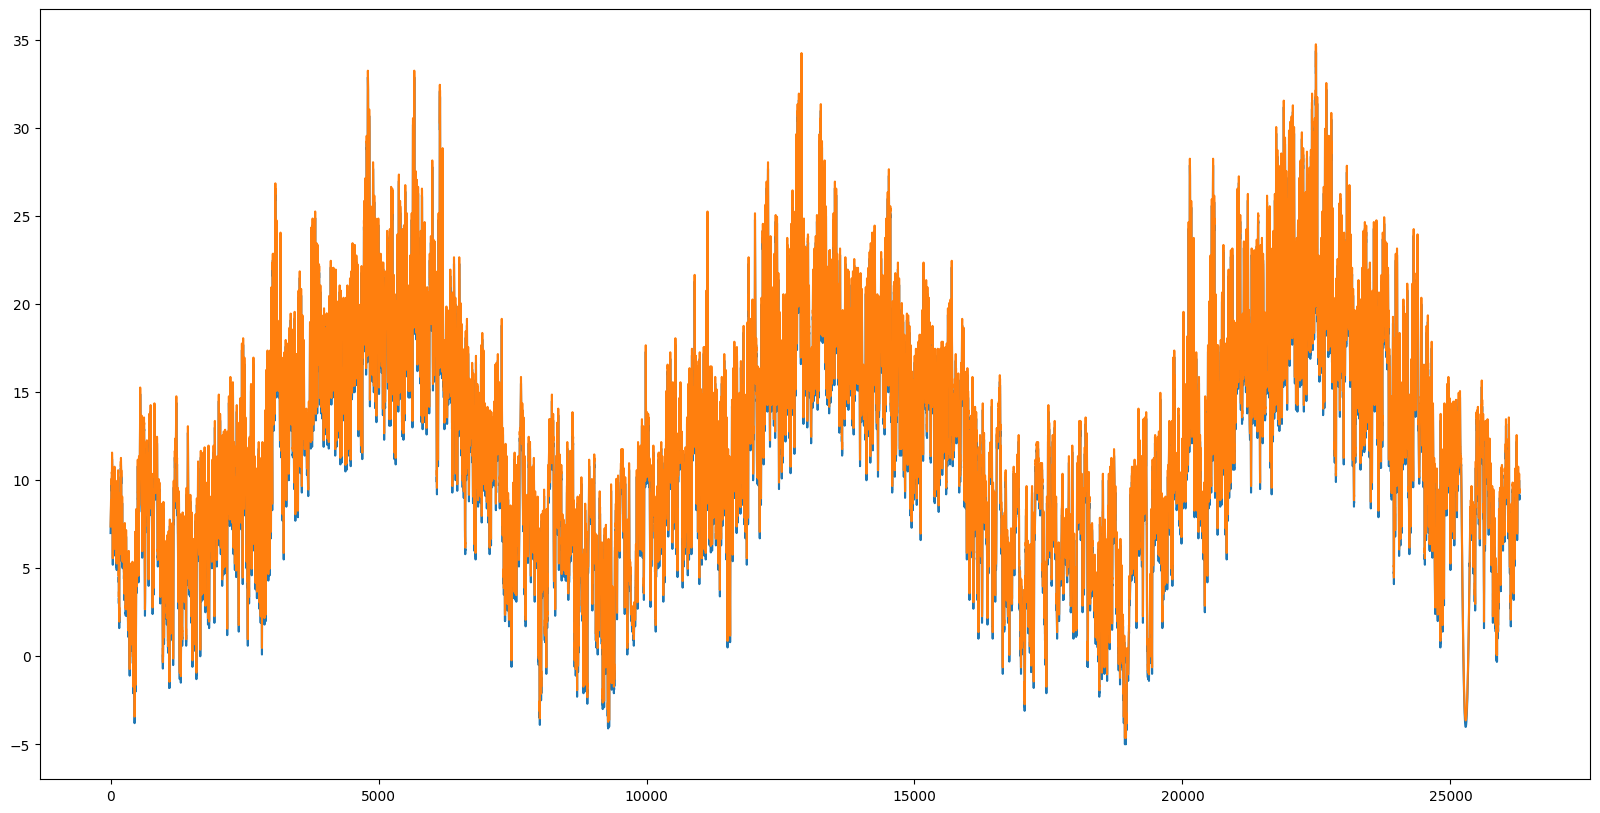

In [14]:
plt.figure(figsize=(20,10)) #plotting

plt.plot(y_real, label='Actuall Data') #actual plot

plt.plot(y_hat, label='Predicted Data') #predicted plot

In [15]:
rmse = np.sqrt(mean_squared_error(y_real, y_hat ))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.371


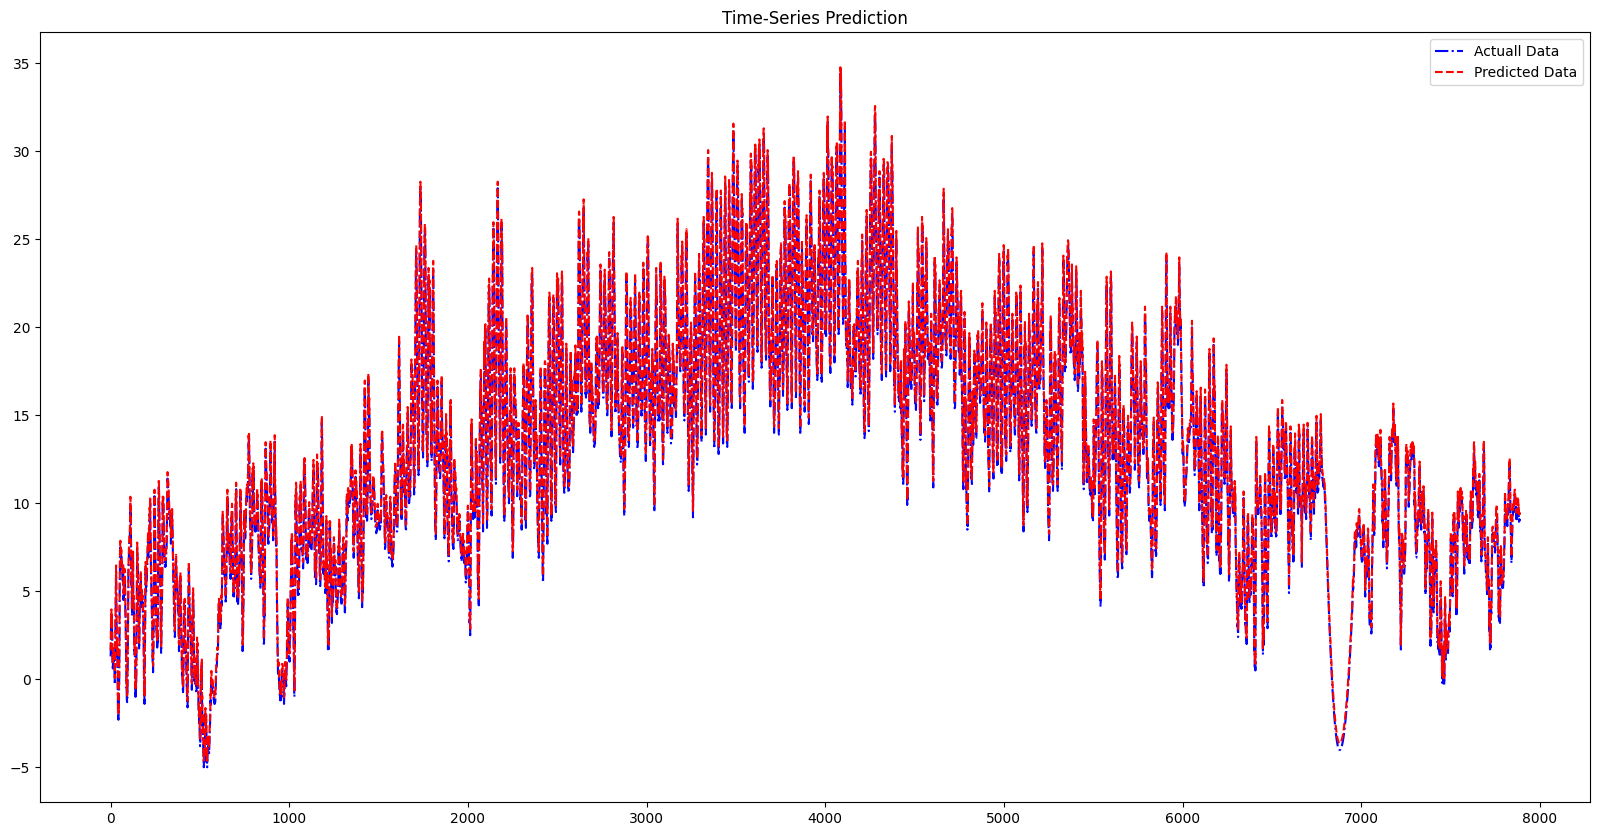

Test RMSE: 0.371


In [16]:
plt.figure(figsize=(20,10)) #plotting

plt.plot(y_real[-test_predict.size:], label='Actuall Data', c='b', linestyle='-.') #actual plot

plt.plot(y_hat[-test_predict.size:], label='Predicted Data',  c='r', linestyle='--') #predicted plot

plt.title('Time-Series Prediction')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_real[-test_predict.size:], y_hat[-test_predict.size:]))
print('Test RMSE: %.3f' % rmse)

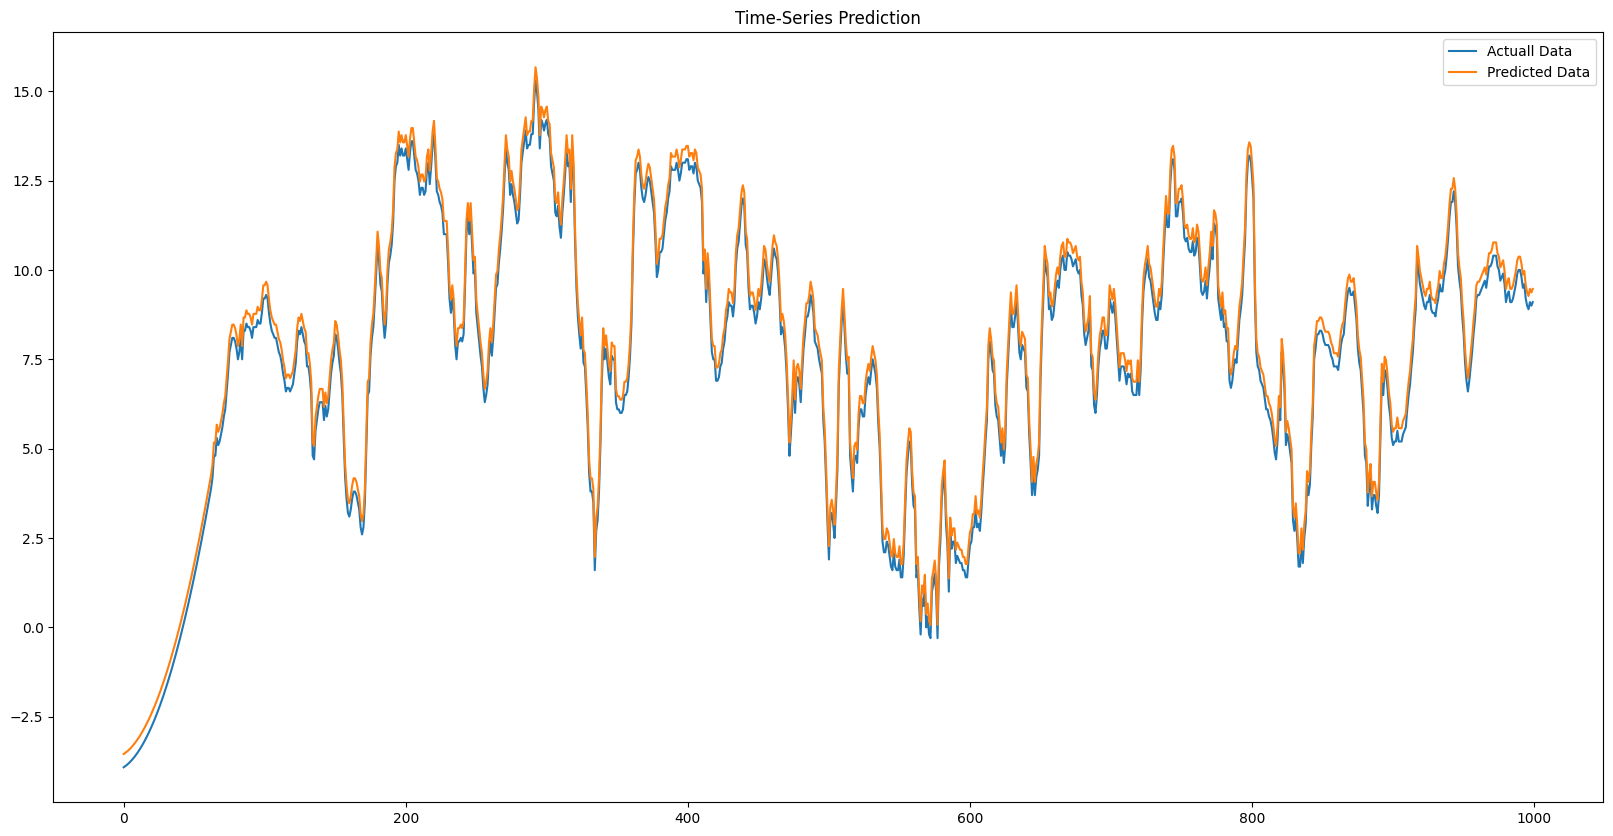

Test RMSE: 0.371


In [18]:

plt.figure(figsize=(20,10)) #plotting

plt.plot(y_real[-1000:], label='Actuall Data') #actual plot

plt.plot(y_hat[-1000:], label='Predicted Data') #predicted plot

plt.title('Time-Series Prediction')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_real[-1000:], y_hat[-1000:]))
print('Test RMSE: %.3f' % rmse)